In [1]:
"""
Adapted from Jason Parisi machine_learning_local_prv.py
"""



from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
import pandas as pd
from matplotlib.pyplot import cm
# import netCDF4 as nc4
from scipy.interpolate import interp1d
import seaborn as sns
from copy import deepcopy
from scipy.stats import spearmanr
from scipy.integrate import simps
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from pathlib import Path
import time as timetime
import numpy as np
import re
import matplotlib.colors as mcolors
from pedestal import *

Importing libraries...
pedinf connection failed
pyuda connection failed
Libraries imported.




In [6]:



def remove_highly_correlated_features(X, threshold=0.8):
    """
    Remove features that are highly correlated with other features.
    
    Parameters:
    - X: numpy array of shape (n_samples, n_features)
    - threshold: correlation threshold for identifying highly correlated features
    
    Returns:
    - X_cleaned: numpy array with highly correlated features removed
    - removed_features: list of indices of features that were removed
    """
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(X, rowvar=False)
    
    # Select upper triangle of correlation matrix
    upper = np.triu(corr_matrix, k=1)
    
    # Find features with correlation greater than the threshold
    to_drop = [i for i in range(upper.shape[0]) if any(upper[i, :] > threshold)]
    
    # Drop features
    X_cleaned = np.delete(X, to_drop, axis=1)
    
    return X_cleaned, to_drop


# load pedestal data from pkl file
a = Shot("allShots", "pkl")


######---- begin jfp edits

# Create a pipeline with standardization and a non-linear model
model = make_pipeline(StandardScaler(),  # Step 2: Generate polynomial features (optional, based on model needs)
	PolynomialFeatures(2), 
    RandomForestRegressor())  # Step 3: Fit a non-linear regression model

#extract pedestal parameters to fit
quantities_filtered = []
n_quantities = 25

quantities_filtered.append(a.H_ped_psin_ne/1e18)
quantities_filtered.append(a.H_ped_psin_pe)
quantities_filtered.append(a.H_ped_psin_te)
quantities_filtered.append(a.H_ped_radius_ne/1e18)
quantities_filtered.append(a.H_ped_radius_pe)
quantities_filtered.append(a.H_ped_radius_te)
quantities_filtered.append(a.Ip)
quantities_filtered.append(a.W_ped_psin_ne/1e18)
quantities_filtered.append(a.W_ped_psin_pe)
quantities_filtered.append(a.W_ped_psin_te)
quantities_filtered.append(a.W_ped_radius_ne/1e18)
quantities_filtered.append(a.W_ped_radius_pe)
quantities_filtered.append(a.W_ped_radius_te)
quantities_filtered.append(a.W_ped)
quantities_filtered.append(a.aratio)
quantities_filtered.append(np.array(a.beamPower,dtype=float)) # cast to float
quantities_filtered.append(a.betaN)
quantities_filtered.append(a.delta)
quantities_filtered.append(a.elmPercent) # NaNs and Infs here
quantities_filtered.append(a.elong)
quantities_filtered.append(a.greenwaldFraction) # NaNs and Infs here
quantities_filtered.append(a.shotIndexed)
quantities_filtered.append(a.ssNBI)
quantities_filtered.append(a.swNBI)
quantities_filtered.append(a.times)

X_temp = np.vstack(quantities_filtered).T
y = a.Beta_ped

# e.g. there is a NaN in 42557 due to elmPercent -- see X_temp[42557]

# check for any NaN vlalues
nan_mask = ~np.isnan(X_temp).any(axis=1)
# filter out rows w/ NaN values
X_noNan = X_temp[nan_mask]
y_noNan = y[nan_mask]

# check for any inf vlalues
inf_mask = ~np.isinf(X_noNan).any(axis=1)
# filter out rows w/ NaN values
X = X_noNan[inf_mask]
y = y_noNan[inf_mask]


#### let's subsample for a quick model training
X_sub = X[::100]
y_sub = y[::100]
model.fit(X_sub, y_sub) ## training in ~5 seconds (4 minutes for ::10)
# Calculate R^2
r2 = model.score(X_sub, y_sub)
print("R^2 random forest:", r2) #

# model.fit(X, y) ## training in ~1hr 10min
# # Calculate R^2
# r2 = model.score(X, y)
# print("R^2 random forest:", r2) #




# ######---- end jfp edits

# # Remove highly correlated features
# X=X.astype("float64")
# X=np.nan_to_num(X, nan=0)
# X[np.where(np.isnan(X))]=0
# X_cleaned, removed_features = remove_highly_correlated_features(X, threshold=0.8)
# print("Removed features indices:", removed_features)

# X = X_cleaned

# #pedestal height is parameter to predict
# y = a.Beta_ped

# # attempts to fix NaN error
# print(X[np.where(np.isinf(X))])
# for i in range(len(X)):
#     X[i][np.where(np.isnan(X[i]))]=0
# y[np.where(np.isnan(y))]=0

# print("yep",X[np.where(np.isnan(X))])
# X.T[0] =X.T[0]/1e18
# print(X)
# print(np.where(np.isnan(y)==True))
# # for i in range(len(X.T)):
# #     z = np.isfinite(X.T[i])
# #     print(np.where(z==False))
# print(X.shape, y.shape)
# print(y)
# print(X.dtype)
# print(y.dtype)


# #fit model
# model.fit(X, y)



Pkl data loaded


R^2 random forest: 0.9524013985024052


In [ ]:
# Here you can replace pickle with joblib or cloudpickle
from pickle import dump
with open("machineLearning.pkl", "wb") as f:
    dump(model, f, protocol=5)

In [ ]:
# Here you can replace pickle with joblib or cloudpickle
from pickle import load
with open("filename.pkl", "rb") as f:
    model = load(f)

Feature importances (sorted):
Feature: x0 x6, Importance: 0.3032466849737475
Feature: x3 x6, Importance: 0.10248565039331023
Feature: x0 x19, Importance: 0.07725548252201528
Feature: x1 x6, Importance: 0.053496293143826104
Feature: x1 x10, Importance: 0.049422282440932476
Feature: x0 x24, Importance: 0.033588650019416896
Feature: x6, Importance: 0.02380464527548307
Feature: x0 x1, Importance: 0.017231767678294763
Feature: x3 x13, Importance: 0.015184688921718734
Feature: x3 x8, Importance: 0.013349940791059325
Feature: x3 x9, Importance: 0.011793012139172516
Feature: x0 x8, Importance: 0.011320229394345089
Feature: x6 x10, Importance: 0.010158983054211902
Feature: x1 x17, Importance: 0.009466397937095545
Feature: x1 x19, Importance: 0.00917675434542504
Feature: x2 x3, Importance: 0.008728049997684444
Feature: x6 x22, Importance: 0.008691674868682001
Feature: x2 x6, Importance: 0.008003211815317695
Feature: x3 x19, Importance: 0.007807032579288551
Feature: x0 x17, Importance: 0.00744747

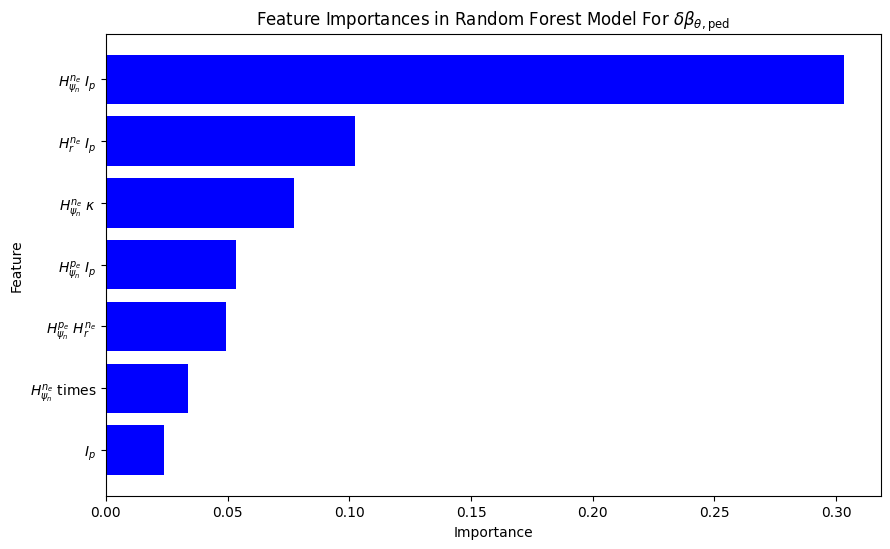

In [7]:

#### FEATURE IMPORTANCE

# Get the RandomForestRegressor from the pipeline
rf_model = model.named_steps['randomforestregressor']

# Feature importances
feature_importances = rf_model.feature_importances_

# Feature names
poly_feature_names = model.named_steps['polynomialfeatures'].get_feature_names_out()
feature_importance_dict = dict(zip(poly_feature_names, feature_importances))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Print sorted features with importances
print("Feature importances (sorted):")
for name, importance in sorted_features:
        print(f"Feature: {name}, Importance: {importance}")

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
feature_names_sorted = [item[0] for item in sorted_features]
importances_sorted = [item[1] for item in sorted_features]


#pedQuants = [r'$\langle | \nabla_N \alpha |^2 \rangle$',r'$\langle \nabla_N \alpha \cdot \nabla_N q \rangle$',r'$\langle | \nabla_N q |^2 \rangle$',r'$\langle \omega_{\kappa}^{\alpha} \rangle$',r'$\langle \omega_{\kappa}^{\alpha}-\omega_{\nabla B}^{\alpha} \rangle$',r'$\langle \omega_{\kappa}^{q} \rangle$',r'$\langle \mathrm{B} \rangle$', r'$\langle \hat{b} \cdot \nabla_N \theta \rangle$']
pedQuants = [r'$H_{\psi_n}^{n_e}$', r'$H_{\psi_n}^{p_e}$', r'$H_{\psi_n}^{t_e}$', r'$H_{r}^{n_e}$', r'$H_{r}^{p_e}$', r'$H_{r}^{t_e}$', r'$I_p$', r'$H_{\psi_n}^{n_e}$', r'$H_{\psi_n}^{p_e}$', r'$H_{\psi_n}^{t_e}$', r'$H_{r}^{n_e}$', r'$H_{r}^{p_e}$', r'$H_{r}^{t_e}$', r'$W_{ped}', r'$a$', r'$NBI$', r'$\beta_N$', r'$\delta$', r'ELM%', r'$\kappa$', r'greenwald', r'shot#', r'ssNBI', r'swNBI', r'times']
# Mapping feature names to geo_quants
variable_mapping = {f'x{i}': name for i, name in enumerate(pedQuants)}
# Function to replace variables in composite names
def replace_feature_names(feature_name, mapping):
        pattern = re.compile(r'x\d+')
        return pattern.sub(lambda x: mapping[x.group()], feature_name)
# Replacing feature names with the actual variable names
feature_names_latex = [replace_feature_names(name, variable_mapping) for name in feature_names_sorted]

# Plot feature importances --- pick only top 7 variables!
top_filter = 7
plt.figure(figsize=(10, 6))
plt.barh(feature_names_latex[:top_filter], importances_sorted[:top_filter], color='b', align='center')
# ~ plt.barh(feature_names_sorted[:top_filter], importances_sorted[:top_filter], color='b', align='center')
# ~ plt.barh(feature_names_sorted[-top_filter:], importances_sorted[-top_filter:], color='b', align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(r'Feature Importances in Random Forest Model For $\delta \beta_{\theta,\mathrm{ped}}$')
plt.gca().invert_yaxis()
plt.show()
#plt.savefig("feature_importance_deltabetaped_nstx.pdf",bbox_inches='tight', pad_inches=0.1)


